In [5]:
from keras.models import load_model

In [6]:
!gdown --id 1GA5YlA0-3EeLc4UT5_Aho57QBxtQURmJ

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1GA5YlA0-3EeLc4UT5_Aho57QBxtQURmJ
To: /content/brats_3d_40epochs.hdf5
100% 68.0M/68.0M [00:00<00:00, 94.3MB/s]


In [7]:
my_model = load_model('brats_3d_40epochs.hdf5', 
                      compile=False)

In [8]:
import tensorflow as tf

In [9]:
dir(tf.lite.OpsSet)

['EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8',
 'SELECT_TF_OPS',
 'TFLITE_BUILTINS',
 'TFLITE_BUILTINS_INT8',
 '__class__',
 '__doc__',
 '__members__',
 '__module__']

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

tflite_model_quant = converter.convert()

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

In [11]:
import pathlib

tflite_models_dir = pathlib.Path("/content")

tflite_model_quant_file = tflite_models_dir/"brat_3d_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

22615256

In [1]:
!gdown --id 1nlMvom8IloCbpuAZ3mpKFayWl-RPQJJB

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1nlMvom8IloCbpuAZ3mpKFayWl-RPQJJB
To: /content/image_0.npy
100% 50.3M/50.3M [00:00<00:00, 106MB/s] 


In [2]:
import numpy as np

image = np.load('image_0.npy')

In [4]:
image[100][100][100]

array([0.57575758, 0.49319372, 0.37297297])

In [13]:
image=np.float32(image)

In [18]:
image.shape

(128, 128, 128, 3)

In [21]:
image = np.expand_dims(image, axis=0)
image.shape

(1, 128, 128, 128, 3)

In [15]:
tflite_model_path = "/content/brat_3d_quant.tflite"

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on input data.
input_shape = input_details[0]['shape']
print(input_shape)




[  1 128 128 128   3]


In [20]:
print(input_details[0]['index'])

0


In [22]:
# Load image
input_data = image

interpreter.set_tensor(input_details[0]['index'], input_data)

In [23]:
interpreter.invoke()

In [38]:
output_data_tflite = interpreter.get_tensor(output_details[0]['index'])

In [39]:
output_data_tflite.shape

(1, 128, 128, 128, 4)

In [41]:
test_prediction_argmax=np.argmax(output_data_tflite, axis=4)[0,:,:,:]
test_prediction_argmax.shape

(128, 128, 128)

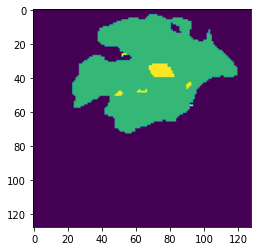

In [43]:
from matplotlib import pyplot as plt

plt.imshow(test_prediction_argmax[:,:, 70])
plt.show()